In [1]:
""" 
MIMIC experiment based on the dataset prepared by prepare_admid_diagnosis.ipynb

The features are the ICD codes, the labele are generated by whether the patient diagnosis contains target diagnosis (i.e., lung cancer)
"""

' \nMIMIC experiment based on the dataset prepared by prepare_admid_diagnosis.ipynb\n\nThe features are the ICD codes, the labele are generated by whether the patient diagnosis contains target diagnosis (i.e., lung cancer)\n'

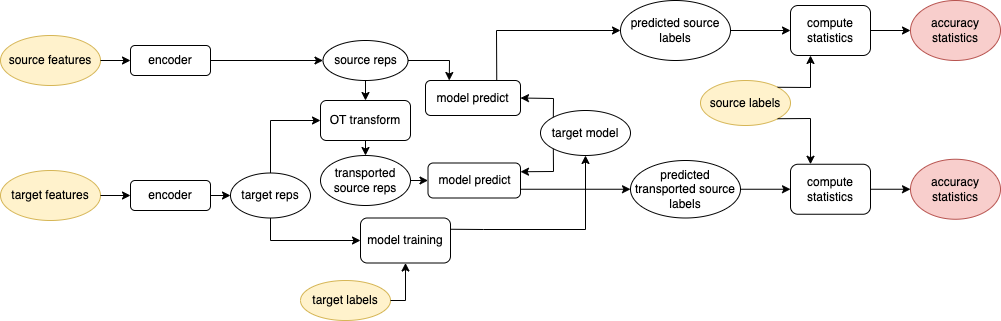

In [2]:
from IPython.display import Image
Image(filename='../../outputs/pipeline_figs/EHR_MIMIC_pipeline.png')

In [3]:
import sys
sys.path.append("/home/wanxinli/deep_patient/")

from common import *
from ast import literal_eval
# %matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import pandas as pd
import random
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score


In [4]:
""" 
Read in dataframe
"""
admid_diagnosis_df = pd.read_csv("../../outputs/mimic/ADMID_DIAGNOSIS.csv", index_col=0, header=0, converters={'ICD codes': literal_eval})
admid_diagnosis_df

,adm_type,gender,ICD codes,duration,diagnosis,label
admid,,,,,,
172335,EMERGENCY,F,"[40301, 486, 58281, 5855, 4254, 2762, 7100, 27...",530460.0,LEG PAIN,0
173633,EMERGENCY,F,"[40301, 5856, 58381, 7100, 5589, 2875, 28521, ...",574560.0,ABDOMINAL PAIN,0
174105,EMERGENCY,M,"[53100, 41071, 2859, 41401, 725]",425460.0,GASTROINTESTINAL BLEED,0
109976,EMERGENCY,M,"[1915, 3314, 53081]",1284240.0,HYDROCEPHALUS,0
178393,ELECTIVE,M,"[41401, 4111, 48283, 2859, 2720, 3051]",485280.0,USA/SDA,0
...,...,...,...,...,...,...
172304,ELECTIVE,F,"[20280, 3485, 7843, 4019, 2720, 53081]",449700.0,LEFT BRAIN TUMOR/SDA,0
152542,EMERGENCY,M,"[566, 25062, 3572, V5867, 42731, 4019, 4280, 5...",415740.0,PERIRECTAL ABSCESS,0
161999,EMERGENCY,M,"[43411, 3485, 3484, 430, 34830, 99731, 51883, ...",692940.0,STROKE;TELEMETRY,0


In [5]:
""" 
Print number of patients for each category
"""
print("female label 0", admid_diagnosis_df.loc[(admid_diagnosis_df['label'] == 0) & (admid_diagnosis_df['gender'] == 'F')].shape[0])
print("female label 1", admid_diagnosis_df.loc[(admid_diagnosis_df['label'] == 1) & (admid_diagnosis_df['gender'] == 'F')].shape[0])
print("male label 0", admid_diagnosis_df.loc[(admid_diagnosis_df['label'] == 0) & (admid_diagnosis_df['gender'] == 'M')].shape[0])
print("male label 1", admid_diagnosis_df.loc[(admid_diagnosis_df['label'] == 1) & (admid_diagnosis_df['gender'] == 'M')].shape[0])

female label 0 25926
female label 1 100
male label 0 32801
male label 1 149


In [6]:
def select_df(df, male_count, female_count):
    """ 
    Select row in the dataframe df with balanced number of labels for males and females
    Specifically, we want to reduce the number of rows with label 0 for males and females

    :param Dataframe df: the dataframe to select samples with label 0 and label 1
    :param int target_count: the number of samples with label 1s and label 0s for target (male). 
    :param int source_count: the number of samples with label 1s and label 0s for source (female). 
    """

    female_1_indices = []
    female_0_indices = []
    male_1_indices = []
    male_0_indices = []

    for index, row in df.iterrows():
        if row['label'] == 0 and row['gender'] == 'F':
            female_0_indices.append(index)
        elif row['label'] == 0 and row['gender'] == 'M':
            male_0_indices.append(index)
        elif row['label'] == 1 and row['gender'] == 'F':
            female_1_indices.append(index)
        elif row['label'] == 1 and row['gender'] == 'M':
            male_1_indices.append(index)
    
    # indices to delete from the dataframe
    # sample the same number of label 0s and label 1s
    delete_female_0_indices = random.sample(female_0_indices, len(female_0_indices)-female_count)
    delete_male_0_indices = random.sample(male_0_indices, len(male_0_indices)-male_count)
    delete_female_1_indices = random.sample(female_1_indices, len(female_1_indices)-female_count)
    delete_male_1_indices = random.sample(male_1_indices, len(male_1_indices)-male_count)

    delete_female_0_indices.extend(delete_male_0_indices)
    delete_female_0_indices.extend(delete_female_1_indices)
    delete_female_0_indices.extend(delete_male_1_indices)
    
    new_df = df.drop(delete_female_0_indices, axis=0, inplace=False)
    return new_df


In [7]:
male_count = 120
female_count = 50
admid_diagnosis_select_df = select_df(admid_diagnosis_df, male_count=male_count, female_count=female_count)


""" 
Print number of patients for each category
"""
print("female label 0", admid_diagnosis_select_df.loc[(admid_diagnosis_select_df['label'] == 0) & (admid_diagnosis_select_df['gender'] == 'F')].shape[0])
print("female label 1", admid_diagnosis_select_df.loc[(admid_diagnosis_select_df['label'] == 1) & (admid_diagnosis_select_df['gender'] == 'F')].shape[0])
print("male label 0", admid_diagnosis_select_df.loc[(admid_diagnosis_select_df['label'] == 0) & (admid_diagnosis_select_df['gender'] == 'M')].shape[0])
print("male label 1", admid_diagnosis_select_df.loc[(admid_diagnosis_select_df['label'] == 1) & (admid_diagnosis_select_df['gender'] == 'M')].shape[0])


female label 0 50
female label 1 50
male label 0 120
male label 1 120


In [8]:
def update_codes(df):
    """ 
    Update code in dataframe, the new code starts from 0.
    We use -1 to denote NA code in later analysis

    returns
        - a new dataframe with the updated codes
        - total number of unique codes in df
    """
    new_code_dict = {} # mapping from old code to new code
    for index, row in df.iterrows():
        cur_codes = row['ICD codes']
        new_codes = []
        for code in cur_codes:
            if code not in new_code_dict:
                new_code_dict[code] = len(new_code_dict) # add a new entry
            new_codes.append(new_code_dict[code])
        df.at[index, 'ICD codes'] = new_codes
    return df, len(new_code_dict)


female_1_df.shape is: (50, 6)
female_0_df.shape is: (50, 6)
male_1_df.shape is: (120, 6)
male_0_df.shape is: (120, 6)


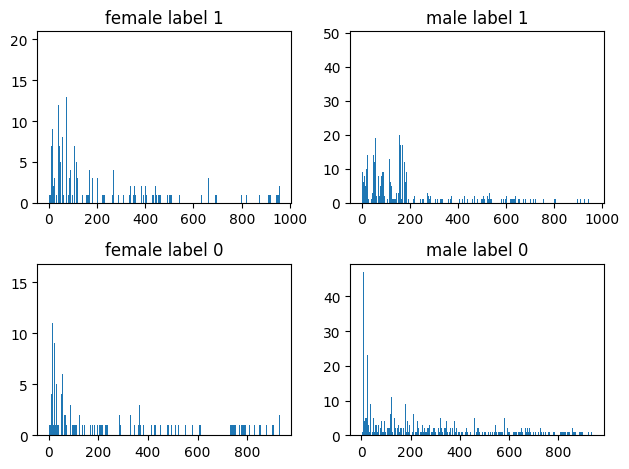

In [9]:
""" 
Plot code distribution for males and females
"""
admid_diagnosis_select_df, _ = update_codes(admid_diagnosis_select_df)
# print(admid_diagnosis_df)
female_1_df = admid_diagnosis_select_df.loc[(admid_diagnosis_select_df['label'] == 1) & (admid_diagnosis_select_df['gender'] == 'F')]
male_1_df = admid_diagnosis_select_df.loc[(admid_diagnosis_select_df['label'] == 1) & (admid_diagnosis_select_df['gender'] == 'M')]
female_0_df = admid_diagnosis_select_df.loc[(admid_diagnosis_select_df['label'] == 0) & (admid_diagnosis_select_df['gender'] == 'F')]
male_0_df = admid_diagnosis_select_df.loc[(admid_diagnosis_select_df['label'] == 0) & (admid_diagnosis_select_df['gender'] == 'M')]
print("female_1_df.shape is:", female_1_df.shape)
print("female_0_df.shape is:", female_0_df.shape)
print("male_1_df.shape is:", male_1_df.shape)
print("male_0_df.shape is:", male_0_df.shape)
bin_width = 1

plt.subplot(2,2,1)
female_1_codes = female_1_df['ICD codes']
female_1_codes = [code for sublist in female_1_codes for code in sublist]
plt.hist(female_1_codes, bins=range(min(female_1_codes), max(female_1_codes)+bin_width, bin_width))
plt.title("female label 1")

plt.subplot(2,2,2)
male_1_codes = male_1_df['ICD codes']
male_1_codes = [code for sublist in male_1_codes for code in sublist]
plt.hist(male_1_codes, bins=range(min(male_1_codes), max(male_1_codes)+bin_width, bin_width))
plt.title("male label 1")

plt.subplot(2,2,3)
female_0_codes = female_0_df['ICD codes']
female_0_codes = [code for sublist in female_0_codes for code in sublist]
plt.hist(female_0_codes, bins=range(min(female_0_codes), max(female_0_codes)+bin_width, bin_width))
plt.title("female label 0")

plt.subplot(2,2,4)
male_0_codes = male_0_df['ICD codes']
male_0_codes = [code for sublist in male_0_codes for code in sublist]
plt.hist(male_0_codes, bins=range(min(male_0_codes), max(male_0_codes)+bin_width, bin_width))
plt.title("male label 0")

plt.tight_layout()
plt.show()


In [10]:
""" 
Question 1: How to select source and target samples such that the embedding learned are different?

We expect that the code distribution of source and target to be very different 

Question 2: Why need embedding?
"""

' \nQuestion 1: How to select source and target samples such that the embedding learned are different?\n\nWe expect that the code distribution of source and target to be very different \n\nQuestion 2: Why need embedding?\n'

In [11]:
def generate_features_labels(df):
    """ 
    Generate source features, source labels, target features and target labels from dataframe df

    TODO: consider making the labels balanced (currently way more 0s than 1s)
    """

    df, num_codes = update_codes(df)

    source_df = df.loc[df['gender'] == 'F']
    target_df = df.loc[df['gender'] == 'M']

    # Prepare target
    target_features = np.empty(shape=[target_df.shape[0], num_codes])
    feature_index = 0
    for index, row in target_df.iterrows():
        code_ind = np.zeros(num_codes)
        for code in row["ICD codes"]:
            code_ind[code] += 1
        target_features[feature_index] = code_ind
        feature_index += 1
    target_labels = np.array(list(target_df['label']))

    # Prepare source
    source_features = np.empty(shape=[source_df.shape[0], num_codes])
    feature_index = 0
    for index, row in source_df.iterrows():
        code_ind = np.zeros(num_codes)
        for code in row["ICD codes"]:
            code_ind[code] += 1
        source_features[feature_index] = code_ind
        feature_index += 1
    source_labels = np.array(list(source_df['label']))

    return target_features, target_labels, source_features, source_labels


In [12]:
target_features, target_labels, source_features, source_labels = generate_features_labels(admid_diagnosis_select_df)


In [13]:
target_features.shape, target_labels.shape, source_features.shape, source_labels.shape

((240, 960), (240,), (100, 960), (100,))

In [14]:
"""
Train deep patient model and generate representations for targets and sources
"""

def custom_train_reps(target_features, source_features, n_components, pca_explain=False):
    """ 
    Customized training algorithm for generating target representations and source representations

    :param bool pca_explain: print the explained variance of each components
    
    :returns: target representations, source representations
    """
    source_pca = PCA(n_components=n_components)
    target_pca = PCA(n_components=n_components)
    target_reps = target_pca.fit_transform(target_features)
    source_reps = source_pca.fit_transform(source_features)

    if pca_explain:
        source_exp_var = source_pca.explained_variance_ratio_
        source_cum_sum_var = np.cumsum(source_exp_var)
        target_exp_var = target_pca.explained_variance_ratio_
        target_cum_sum_var = np.cumsum(target_exp_var)
        print("Cummulative variance explained by the source PCA is:", source_cum_sum_var)
        print("Cummulative variance explained by the target PCA is:", target_cum_sum_var)

    return target_reps, source_reps

In [15]:
target_reps, source_reps = custom_train_reps(target_features, source_features, n_components=50, pca_explain=True)


Cummulative variance explained by the source PCA is: [0.05516318 0.09488807 0.13146065 0.16510964 0.19544055 0.22369176
 0.25040813 0.27631394 0.30062346 0.32465056 0.3469983  0.36852295
 0.38962556 0.40975789 0.42960089 0.44869135 0.46706013 0.48412637
 0.50061247 0.51629986 0.53155916 0.54671704 0.56138316 0.57548248
 0.58915326 0.60267896 0.61577598 0.62807858 0.64028795 0.65216691
 0.66365274 0.6746831  0.68548113 0.69566418 0.70572244 0.71551412
 0.72508502 0.73439292 0.74327767 0.75213629 0.76087923 0.7692332
 0.77752225 0.7853741  0.79310704 0.80074073 0.80792137 0.8149061
 0.82174175 0.82837729]
Cummulative variance explained by the target PCA is: [0.03927407 0.07176611 0.10028043 0.12625579 0.14789295 0.1678706
 0.18715854 0.20429745 0.22056681 0.23604066 0.25136941 0.26597338
 0.28029013 0.29406767 0.30752842 0.32090664 0.33359385 0.34612783
 0.35829299 0.36968822 0.38092294 0.39200415 0.40304111 0.41378455
 0.4240971  0.43415836 0.44397183 0.45366816 0.46308316 0.47231266
 0

In [16]:
target_reps.shape, source_reps.shape

((240, 50), (100, 50))

In [17]:
""" 
Fit the model, transport and make predictions
"""
clf = LogisticRegression()
# clf = SVC(kernel='rbf')
# clf = SVC()
clf.fit(target_reps, target_labels)
target_preds = clf.predict(target_reps)
source_preds = clf.predict(source_reps)
trans_source_reps = trans_source2target(source_reps, target_reps)
trans_source_preds = clf.predict(trans_source_reps)

In [18]:
# """ 
# Unbalanced OT
# """
# a = np.ones((female_count*2,)) / female_count*2
# b = np.ones((male_count*2,)) / male_count*2
# print("a shape is:", a.shape)
# print("b shape is:", b.shape)
# M = ot.dist(source_reps, target_reps)
# M /= M.max()
# print("M shape is:", M.shape)

# reg = 0.005
# reg_m_kl = 10
# # reg_m_l2 = 5
# # mass = 0.7

# coupling = ot.unbalanced.sinkhorn_unbalanced(a, b, M, reg, reg_m_kl)
# # kl_uot = ot.unbalanced.mm_unbalanced(a, b, M, reg_m_kl, div='kl')
# # l2_uot = ot.unbalanced.mm_unbalanced(a, b, M, reg_m_l2, div='l2')
# # coupling = ot.partial.partial_wasserstein(a, b, M, m=mass)
# print("source_reps shape is:", source_reps.shape)
# print("target_reps shape is:", target_reps.shape)
# print("coupling shape is:", coupling.shape)
# trans_source_reps = np.transpose(np.matmul(np.transpose(target_reps), np.transpose(coupling)))
# print("trans_source_reps shape is:", trans_source_reps.shape)
# trans_source_preds = clf.predict(trans_source_reps)

# np.savetxt("../../outputs/mimic/target_reps.txt", target_reps, fmt="%.1f")
# np.savetxt("../../outputs/mimic/source_reps.txt", source_reps, fmt="%.1f")
# np.savetxt("../../outputs/mimic/trans_source_reps.txt", trans_source_reps, fmt="%.1f")
# np.savetxt("../../outputs/mimic/coupling.txt", coupling)


In [19]:
""" 
Print the accuracy stats
"""

print("target accuracy is:", accuracy_score(target_labels, target_preds))
print("target precision is:", precision_score(target_labels, target_preds))
print("target recall is:", recall_score(target_labels, target_preds))
print("source accuracy is:", accuracy_score(source_labels, source_preds))
print("source precision is:", precision_score(source_labels, source_preds))
print("source recall is:", recall_score(source_labels, source_preds))
print("trans source accuracy is:", accuracy_score(source_labels, trans_source_preds))
print("trans source precision is:", precision_score(source_labels, trans_source_preds))
print("trans source recall is:", recall_score(source_labels, trans_source_preds))

target accuracy is: 0.9166666666666666
target precision is: 0.9385964912280702
target recall is: 0.8916666666666667
source accuracy is: 0.5
source precision is: 0.5
source recall is: 0.52
trans source accuracy is: 0.57
trans source precision is: 0.5714285714285714
trans source recall is: 0.56


In [20]:
""" 
Automate this process
"""

def entire_proc(n_components):
    male_count = 120
    female_count = 100
    admid_diagnosis_select_df = select_df(admid_diagnosis_df, male_count=male_count, female_count=female_count)

    target_features, target_labels, source_features, source_labels = generate_features_labels(admid_diagnosis_select_df)

    target_reps, source_reps = custom_train_reps(target_features, source_features, n_components)

    clf = LogisticRegression()
    clf.fit(target_reps, target_labels)
    target_preds = clf.predict(target_reps)
    source_preds = clf.predict(source_reps)
    trans_source_reps = trans_source2target(source_reps, target_reps)
    trans_source_preds = clf.predict(trans_source_reps)
    target_accuracy = accuracy_score(target_labels, target_preds)
    target_f1 = f1_score(target_labels, target_preds)
    source_accuracy = accuracy_score(source_labels, source_preds)
    source_f1 = f1_score(source_labels, source_preds)
    trans_source_accuracy = accuracy_score(source_labels, trans_source_preds)
    trans_source_f1 = f1_score(source_labels, trans_source_preds)
    return target_accuracy, target_f1, source_accuracy, source_f1, \
        trans_source_accuracy, trans_source_f1



In [21]:
entire_proc(50)

(0.9291666666666667,
 0.9264069264069265,
 0.42,
 0.4821428571428571,
 0.555,
 0.5572139303482587)

In [22]:
def multi_proc(n_components = 10, iteration=20):
    res = np.empty(shape=[iteration, 6])
    for i in range(iteration):
        print("iteration:", i)
        cur_res = entire_proc(n_components)
        res[i] = cur_res
    res_df = pd.DataFrame(res, columns = ['target_accuracy', 'target_f1', 'source_accuracy', 'source_f1', 'trans_source_accuracy', 'trans_source_f1'])
    res_df.to_csv("../../outputs/mimic/score.csv", index=False, header=True)
    return res
    

In [23]:
res = multi_proc(n_components = 50, iteration=200)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6


/home/wanxinli/.local/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21


/home/wanxinli/.local/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42


/home/wanxinli/.local/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60


/home/wanxinli/.local/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteration: 69
iteration: 70
iteration: 71
iteration: 72


/home/wanxinli/.local/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 73
iteration: 74
iteration: 75
iteration: 76
iteration: 77
iteration: 78
iteration: 79
iteration: 80
iteration: 81
iteration: 82
iteration: 83


/home/wanxinli/.local/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 84
iteration: 85
iteration: 86
iteration: 87
iteration: 88
iteration: 89
iteration: 90
iteration: 91
iteration: 92
iteration: 93
iteration: 94
iteration: 95
iteration: 96
iteration: 97
iteration: 98
iteration: 99


number of stats is: 100
number of 0 in incre is: 1
number of elements > 0 is: 67
number of elements < 0 is: 32
average trans source to source accuracy increment is: 0.030899999999999997
median trans source to source accuracy increment is: 0.03249999999999997
average trans source to source accuracy f1 is: 0.01856298976052108
median trans source to source accuracy f1 is: 0.01747010439547242
average trans source to source accuracy is: 1.0874088964740278
median trans source to source accuracy is: 1.0599718381976446
average trans source to source f1 is: 1.0520353634559125
median trans source to source f1 is: 1.0315896276194785


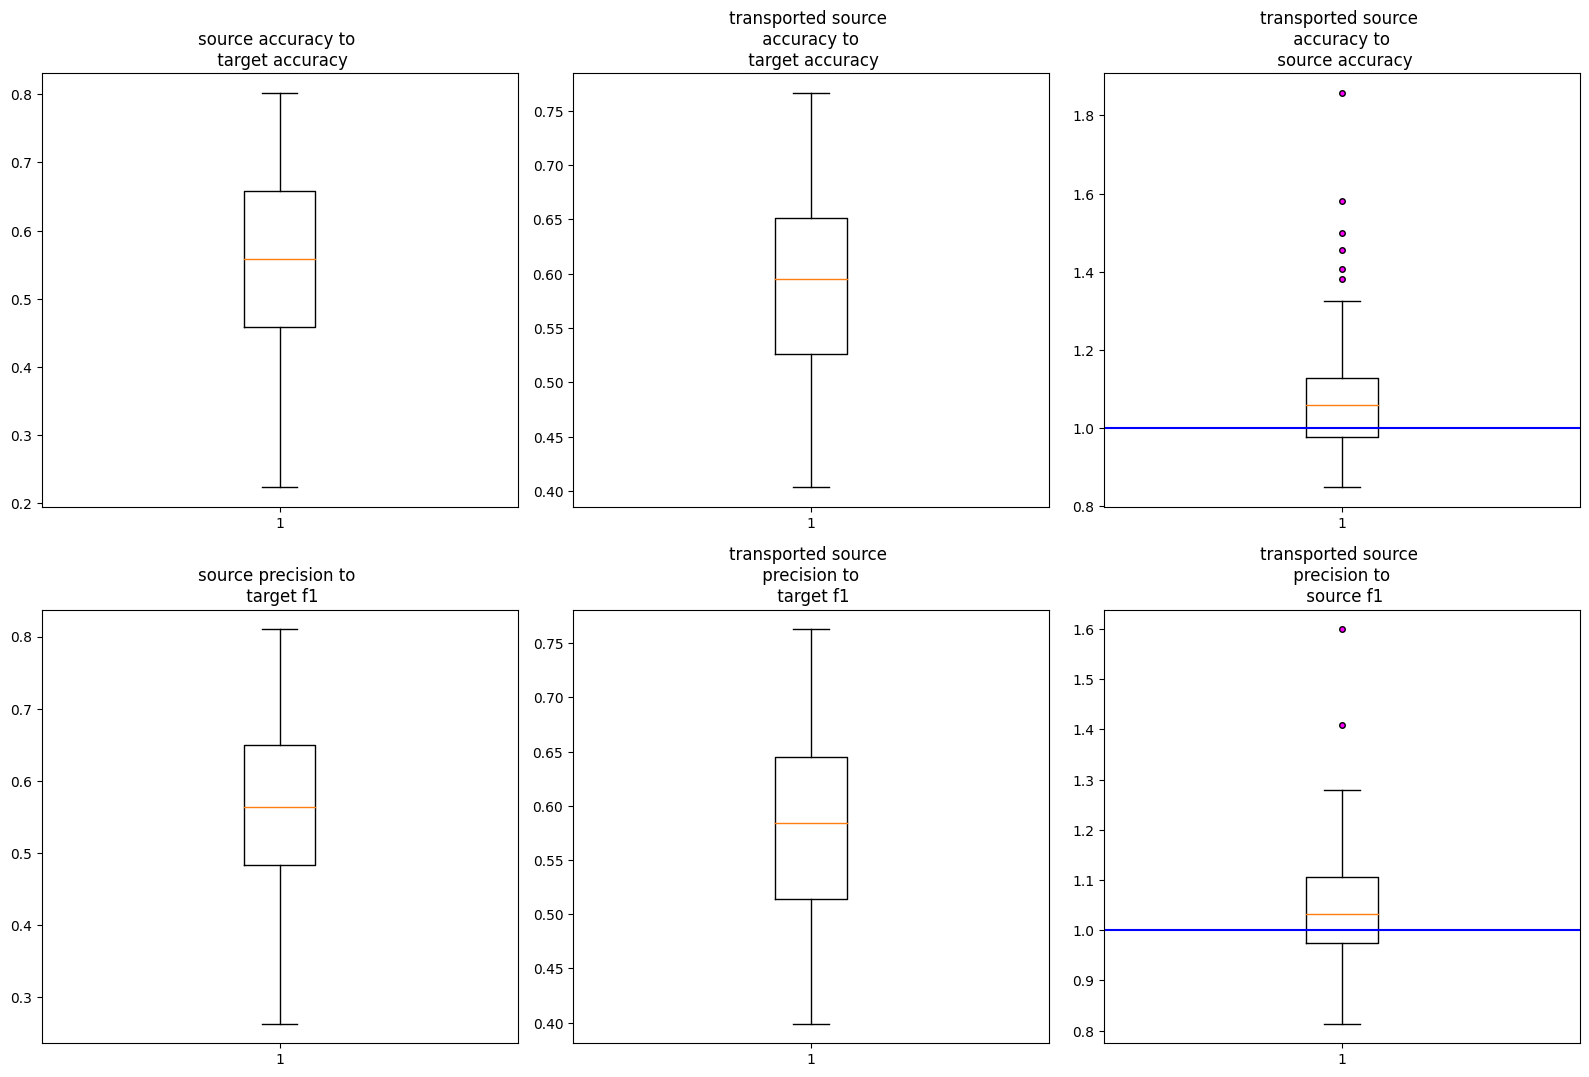

In [24]:
box_plot("../../outputs/mimic/score.csv", filter=False)

average trans source to source accuracy increment is 3.1%
median trans source to source accuracy increment is 3.2%
average trans source to source accuracy f1 is 1.9%
median trans source to source accuracy f1 is 1.7%


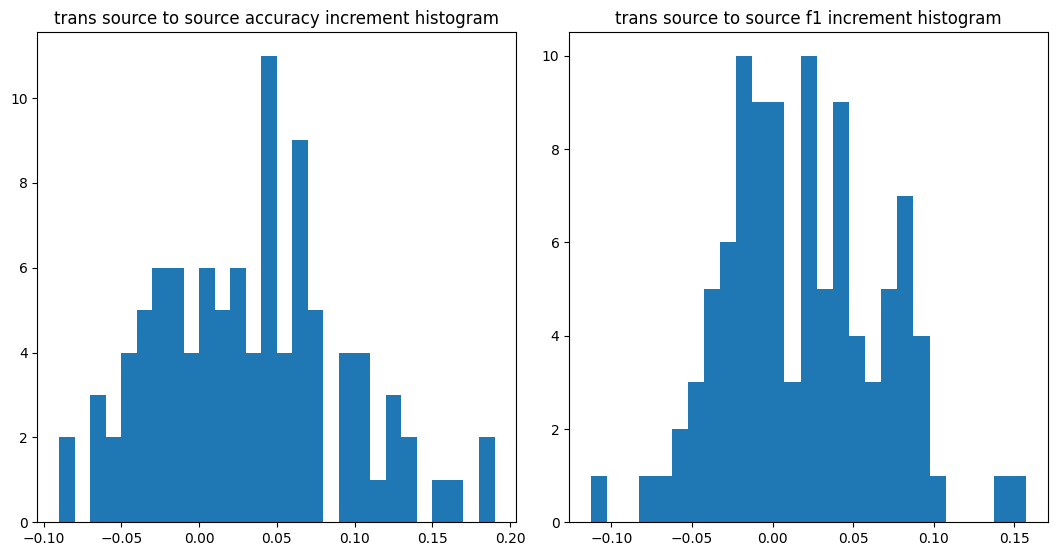

In [25]:
hist_plot("../../outputs/mimic/score.csv", filter=False)

In [26]:
def vis_emb_dim3_unordered(target_reps, target_labels, source_reps, source_labels, \
    trans_source_reps):
    """ 
    Visualize the embedding space of dimension 3 for target represenatations, source representations, \
        transported source representations with different labels annotated in different colors
    """
    fig = plt.figure(figsize=[10, 4])

    ax = fig.add_subplot(1,3,1, projection='3d')
    cdict = {1: 'purple', 0: 'orange'}
    
    for l in np.unique(target_labels):
        ix = np.where(target_labels == l)
        ax.scatter(target_reps[ix, 0], target_reps[ix, 1], target_reps[ix, 2], label = l, s = 5, color=cdict[l])
    ax.legend()
    ax.set_title("Target")

    ax = fig.add_subplot(1,3,2, projection='3d')
    for l in np.unique(source_labels):
        ix = np.where(source_labels == l)
        ax.scatter(source_reps[ix, 0], source_reps[ix, 1], source_reps[ix, 2], label = l, s = 5, color=cdict[l])
    ax.legend()
    ax.set_title("Source")

    ax = fig.add_subplot(1,3,3, projection='3d')
    for l in np.unique(source_labels):
        ix = np.where(source_labels == l)
        ax.scatter(trans_source_reps[ix, 0], trans_source_reps[ix, 1], trans_source_reps[ix, 2], label = l, s = 5, color=cdict[l])
    ax.legend()
    ax.set_title("Trans source")
    
    plt.show()
    


In [27]:
entire_proc()


TypeError: entire_proc() missing 1 required positional argument: 'n_components'

In [ ]:
# vis_emb_dim3_unordered(target_reps, target_labels, source_reps, source_labels, trans_source_reps)

In [ ]:
# # fig = plt.figure()

# # ax = fig.add_subplot(1,3,1, projection='3d')
# plt.figure(figsize=(10, 50))
# plt.scatter(target_reps[:, 0], target_reps[:, 1], target_reps[:, 2], c=target_labels)
# plt.title("Target")
# plt.show()

In [ ]:

# # creating 3d plot using matplotlib 
# # in python
  
# # for creating a responsive plot
# %matplotlib notebook
  
# # importing required libraries
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.pyplot as plt
  
# # creating random dataset
# xs = [14, 24, 43, 47, 54, 66, 74, 89, 12,
#       44, 1, 2, 3, 4, 5, 9, 8, 7, 6, 5]
  
# ys = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 6, 3,
#       5, 2, 4, 1, 8, 7, 0, 5]
  
# zs = [9, 6, 3, 5, 2, 4, 1, 8, 7, 0, 1, 2, 
#       3, 4, 5, 6, 7, 8, 9, 0]
  
# # creating figure
# fig = plt.figure()
# ax = Axes3D(fig)
  
# # creating the plot
# plot_geeks = ax.scatter(xs, ys, zs, color='green')
  
# # setting title and labels
# ax.set_title("3D plot")
# ax.set_xlabel('x-axis')
# ax.set_ylabel('y-axis')
# ax.set_zlabel('z-axis')
  
# # displaying the plot
# plt.show()

In [ ]:
# %matplotlib notebook
# # aka import ipympl

# import matplotlib.pyplot as plt

# plt.plot([0, 1, 2, 2])
# plt.show()

In [ ]:
""" 
Fit the model (on features), transport and make predictions
"""
clf = LogisticRegression()
# clf = SVC()
clf.fit(target_features, target_labels)
target_preds = clf.predict(target_features)
source_preds = clf.predict(source_features)

# trans_source_features = trans_source2target(source_features, target_features)

ot_emd = ot.da.SinkhornTransport(reg_e=1e-1, max_iter=10000)
# ot_emd = ot.da.EMDTransport()
ot_emd.fit(Xs=source_features, Xt=target_features)
trans_source_features = ot_emd.transform(Xs=source_features)

trans_source_preds = clf.predict(trans_source_features)

np.savetxt("../../outputs/mimic/target_features.txt", target_features, fmt="%.1f")
np.savetxt("../../outputs/mimic/source_features.txt", source_features, fmt="%.1f")
np.savetxt("../../outputs/mimic/trans_source_features.txt", trans_source_features, fmt="%.1f")
np.savetxt("../../outputs/mimic/coupling.txt", ot_emd.coupling_)


In [ ]:
""" 
Focus on this
Print the accuracy stats
"""

print("target accuracy is:", accuracy_score(target_labels, target_preds))
print("target precision is:", precision_score(target_labels, target_preds))
print("target recall is:", recall_score(target_labels, target_preds))
print("source accuracy is:", accuracy_score(source_labels, source_preds))
print("source precision is:", precision_score(source_labels, source_preds))
print("source recall is:", recall_score(source_labels, source_preds))
print("trans source accuracy is:", accuracy_score(source_labels, trans_source_preds))
print("trans source precision is:", precision_score(source_labels, trans_source_preds))
print("trans source recall is:", recall_score(source_labels, trans_source_preds))

target accuracy is: 0.96
target precision is: 0.9893617021276596
target recall is: 0.93
source accuracy is: 1.0
source precision is: 1.0
source recall is: 1.0
trans source accuracy is: 0.75
trans source precision is: 0.7272727272727273
trans source recall is: 0.8
